In [314]:
# Libraries

import pandas as pd
import numpy as np
import re
from pprint import pprint
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [403]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [315]:
# Reading CSV files

optim_f_df=pd.read_csv('data/BGEIDSC.EF2EFFP.csv')                   # fuel optimization 
trans_f_df=pd.read_csv('data/BGETCHDATA.PTCHTRANH.csv')              # fuel transactions
event_f_df=pd.read_csv('data/Extranet2.ExactFuelEvents.csv')         # fuel events
level_f_df=pd.read_csv('data/Extranet2.ExactFuelTankLevels.csv')     # fuel levels
truck_v_df=pd.read_csv('data/IBGEFILE.UNITS.csv')                    # trucks 
perfo_v_df=pd.read_csv('data/Extranet2.QCPerformanceExtracts.csv')   # vehicle performance


## Overviewing Data

In [316]:
event_f_df.head(1)
level_f_df.head()

#optim_f_df.head(3)

# TRUCK     Unit Number               *****                                           [TU]
# ACTIVE    Active Flag (for fuel optimization)
# SENDFUEL  Send Fuel Flag (for fuel optimization)
# SENDROUTE Send Route Flag (for fuel optimization)
# TANKCAP   Tank Capacity (gallons)                                       * 5 types
# AVGMPG    MPG used for Fuel optimization (real value is closer to 7mpg)


#trans_f_df.head(3)

# TRNID   Transaction ID 
# TRNDAT  Transaction Date (YYYYMMDD)
# TRNTIM  Transaction Time (HHMM)
# TRNTS#  Station ID
# TRNTSN  Station Name
# TRNSTC  Station City
# TRNST   Station State
# TRNDRI  Driver Code                                                          [DR]
# TRNUNT  Unit ID                                                              [TU]
# TRNPI1  Item Code 1
# TRNPQ1  Item Quantity 1
# TRNPI2  Item Code 2
# TRNPQ2  Item Quantity 2
# TRNPI3  Item Code 3
# TRNPQ3  Item Quantity 3
# TRNPI4  Item Code 4
# TRNPQ4  Item Quantity 4
# TRNPI5  Item Code 5
# TRNPQ5  Item Quantity 5
# TRNPI6  Item Code 6
# TRNPQ6  Item Quantity 6

# Actual fuel transactions will have an item code of ULSD or FUEL, CDSL, DSL1, BDSL, 
# and could be in any of the Item slots 1-6

level_f_df.head(3)

# Id                AutoNumber id
# TankId            Tank Sensor #         (for our trucks, will always be 1)
# TankLevelPercent  Percentage Reading    0-100.00
# TankLevelGallons  Gallons               (Percentage * Tank Capacity) (calculated)
# ExactFuelEventId  Foreign Key to ExactFuelEvent                                       [EV]

,Id,TankId,TankLevelPercent,TankLevelGallons,ExactFuelEventId
0,10391480,1,82.8,165.6,12667508
1,10391482,1,72.4,144.8,12667510
2,10391505,1,57.1,114.2,12667533


In [317]:
# This block creates a list of truck IDs as numeric values (valid_trucks).

good_trux_3 = optim_f_df['TRUCK']
list_of_trucks_3 = list(set(good_trux_3))
valid_trucks_o = [x for x in list_of_trucks_3 if (x >= 1 | x < 9999)]
len(valid_trucks_o)
#418

418

In [318]:
# This block creates a list of truck IDs as numeric values (valid_trucks).

#good_trux = trans_f_df['TRNUNT'].str.extract('(\d+)')
#list_of_trucks = list(set(good_trux))
#num_trux = pd.to_numeric(list_of_trucks, downcast='integer')
#valid_trucks_t = [x for x in num_trux if np.isnan(x) != True]
#print(valid_trucks_t)

good_trux_2 = event_f_df['EquipmentID']
list_of_trucks_2 = list(set(good_trux_2))
valid_trucks_e = [x for x in list_of_trucks_2 if (x >= 1 | x < 9999)]
len(valid_trucks_e)
#327

327

In [404]:
# This block creates a list of driver codes.

good_driv = trans_f_df['TRNDRI'].str.extract('(\S+)')
list_of_drivs = list(set(good_driv))
valid_driv_t = [x for x in list_of_drivs if str(x) != 'nan']

len(valid_driv_t)
#938

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



938

In [320]:
# transaction codes for fuel transactions
trx_list = ['ULSD', 'FUEL', 'CDSL', 'DEFC', 'DSL1', 'BDSL']
df_fuel_trans = trans_f_df[trans_f_df['TRNPI1'].isin(trx_list)]
# We don't need the TRNPI 2-6 column since they do not contain any valid fuel item (I have checked them 
# but the queries are not here.)
df_fuel_trans = df_fuel_trans.drop(['TRNPI2','TRNPI3','TRNPI4','TRNPI5','TRNPI6','TRNPQ2','TRNPQ3',\
                                    'TRNPQ4','TRNPQ5','TRNPQ6'], axis=1)
df_fuel_trans = df_fuel_trans.drop(['TRNID','TRNDAT','TRNTIM','TRNTS#','TRNTSN','TRNSTC','TRNST', 'TRNPI1'], axis=1)
df_fuel_trans.head(5)
df_fuel_trans.shape
# (104057, 3)
#df_fuel_trans = df_fuel_trans[df_fuel_trans.TRNDRI.isin(valid_driv_t)]
#df_fuel_trans.shape
#df_fuel_trans = df_fuel_trans[df_fuel_trans.TRNUNT.isin(valid_trucks_e)]
#df_fuel_trans.shape
#df_fuel_trans = df_fuel_trans[(df_fuel_trans.TRNDRI.isin(valid_driv_t) == True) & (df_fuel_trans.TRNUNT.isin(valid_trucks_e) == True)]


#df_fuel_trans.head(5)


(104057, 3)

In [321]:
# this converts blanks to string and then strip will make it a Nan and then it can be removed
df_fuel_trans['TRNUNT'] = df_fuel_trans['TRNUNT'].apply(str)
df_fuel_trans['TRNUNT'] = df_fuel_trans['TRNUNT'].str.strip()
df_fuel_trans['TRNDRI'] = df_fuel_trans['TRNDRI'].apply(str)
df_fuel_trans['TRNDRI'] = df_fuel_trans['TRNDRI'].str.strip()
df_fuel_trans.isnull().values.any()
print(df_fuel_trans['TRNUNT'].dtype)
print(df_fuel_trans['TRNDRI'].dtype)

object
object


#This gets us a compact df with driver, truck and fuel level across all fuel transactions

In [405]:


df_fuel_by_truck_driver = df_fuel_trans.groupby(['TRNDRI','TRNUNT'], as_index=False)['TRNPQ1'].sum()
#df_fuel_by_truck_driver['TRNDRI'].replace('', np.nan, inplace=True)   
#df_fuel_by_truck_driver['TRNUNT'].replace('', np.nan, inplace=True)
#df_fuel_by_truck_driver.dropna(axis=0, how='any')
#df_fuel_by_truck_driver = df_fuel_by_truck_driver[~(df_fuel_by_truck_driver[['TRNDRI']] == '').any(axis=1)]
#df_fuel_by_truck_driver = df_fuel_by_truck_driver[df_fuel_by_truck_driver['TRNDRI'].notnull() & df_fuel_by_truck_driver['TRNUNT'].notnull()]
df_fuel_by_truck_driver = df_fuel_by_truck_driver.rename(columns={'TRNDRI':'DriverID', 'TRNUNT':'EquipmentID', \
                                                                  'TRNPQ1':'fuel'})
df_fuel_by_truck_driver.head()
#df_fuel_by_truck_driver = df_fuel_by_truck_driver.reset_index()

#df_fuel_by_truck_driver = df_fuel_by_truck_driver.reset_index()
#df_fuel_by_truck_driver.info()
df_fuel_by_truck_driver.head()
#df.groupby(['Country', 'Item_Code'])[["Y1961", "Y1962", "Y1963"]].sum()


,DriverID,EquipmentID,fuel
0,,1564,86.21
1,,1568,466.28
2,,1620,161.95
3,,1735,81.84
4,,1736,88.83


In [323]:
event_f_df.head(3)

# Id                AutoNumber ID                                                   [EV]
# ESS_Id            Omnitracs Event Subscriber Service Event Id
# EventTimeStamp    DateTime of Event (normalized to Central Time)
# EquipmentID       Unit Number                                                     [TU] (?)
# MCTNumber         Mobile Communications Terminal ID
# EquipmentType     should always read ‘tractor’
# DriverId          Driver Code Assigned to unit at time of reading (varchar(6))    [DR] (?)
# Latitude          decimal degrees latitude at time of reading
# Longitude         decimal degrees longitude at time of reading
# LocationTimeStamp DateTime of location reading
# Speed             MPH at time of reading
# Heading           direction of travel at time of reading
# Odometer          unit odometer at time of reading
# IgnitionStatus    1=on, 2=off
# EFReportReason    0=ignition on, 1=ignition off, 2=timer

# NOTE: Discard equipment IDs that are wrongfully replaced by MCTNumber
event_f_df.shape
#(8495130, 15)

(8495130, 15)

In [406]:
# how many truck events for each truck??
df_events_trucks = event_f_df[~(event_f_df[['Odometer']] == 0).any(axis=1)]

#df_events_truck = df_events_truck.EquipmentID.value_counts().sort_values(ascending=False)
#df_events_truck = pd.DataFrame(data=df_events_truck)
#df_events_truck = df_events_truck.reset_index();
#df_events_truck.columns = ['EquipmentID','Count']
#df_events_truck.head()
df_events_trucks.head()
df_events_trucks.shape
#df_events_trucks.info()

(8297759, 15)

In [408]:
# Calculate the miles travelled by driver truck combination
df_events_trucks['DriverID'] = df_events_trucks['DriverID'].apply(str)
df_events_trucks['EquipmentID'] = df_events_trucks['EquipmentID'].apply(str)
df_events_trucks['DriverID'] = df_events_trucks['DriverID'].str.strip()
df_events_trucks['EquipmentID'] = df_events_trucks['EquipmentID'].str.strip()

df_events_trucks.isnull().values.any()
print(df_events_trucks['DriverID'].dtype)
print(df_events_trucks['EquipmentID'].dtype)

df_mileage = pd.DataFrame()
df_mileage['lowest'] = df_events_trucks.groupby(['DriverID','EquipmentID'])['Odometer'].min()
df_mileage['highest'] = df_events_trucks.groupby(['DriverID','EquipmentID'])['Odometer'].max()
df_mileage['miles'] = (df_mileage['highest'] - df_mileage['lowest'])

df_mileage.dropna()
df_mileage = df_mileage.reset_index()
df_mileage.head()
#df_mileage.info()
#filtered_data = df[df.topping == 'pineapple']
great_driver_list = ['SMID', 'BEVL', 'RICS', 'NEWR', 'MARC', 'LOVH']
#df_mileage[df_mileage.DriverID.isin(great_driver_list)]
#df_mpg.loc[df_mpg['DriverID'] =='LOVH',:]  
#filtered_data

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

object
object


In [326]:
#df_mileage[df_mileage.DriverID.isin(great_driver_list)]

In [409]:
#df_mileage.head()
#df_mileage.info()

In [410]:
#df_fuel_by_truck_driver.head()
#df_fuel_by_truck_driver.info()


In [412]:
#df_mileage[df_mileage.DriverID.isin(great_driver_list)]


df_fuel_by_truck_driver['DriverID'] = df_fuel_by_truck_driver['DriverID'].apply(str)
df_mileage['DriverID'] = df_mileage['DriverID'].apply(str)
df_fuel_by_truck_driver['EquipmentID'] = df_fuel_by_truck_driver['EquipmentID'].apply(str)
df_mileage['EquipmentID'] = df_mileage['EquipmentID'].apply(str)



#df_merged = pd.merge(df_mileage, df_fuel_by_truck_driver,  on=['DriverID','EquipmentID'], how='inner')
df_merged = pd.merge(df_mileage, df_fuel_by_truck_driver, left_on=['DriverID','EquipmentID'], right_on=['DriverID','EquipmentID'], how='inner')
#print(pd.merge(df1,df2, on=['HPI','Int_rate']))

#df_merged[df_merged.DriverID.isin(great_driver_list)]

df_merged.head()
#df_merged.info()
#df_merged.shape
#(2981, 7)
#df_merged.isnull().sum()

,DriverID,EquipmentID,lowest,highest,miles,fuel
0,ABBV,1821,174238.5,233502.4,59263.9,8288.76
1,ADAG,1857,119691.4,148476.9,28785.5,4064.35
2,ADAR,1950,69148.0,226432.8,157284.8,21798.23
3,ALBJ,1558,478726.4,505196.5,26470.1,4373.40
4,ALBJ,1743,423467.7,463570.1,40102.4,5779.27


In [413]:
df_merged['mpg'] = df_merged['miles']/df_merged['fuel']
df_mpg = df_merged[(df_merged['mpg'] > 3) & (df_merged['mpg'] < 10)]
df_mpg.head()
#df_merged.shape
#df_mpg.describe()
#df_merged.DriverID.value_counts(dropna = False)

,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg
0,ABBV,1821,174238.5,233502.4,59263.9,8288.76,7.149911
1,ADAG,1857,119691.4,148476.9,28785.5,4064.35,7.082436
2,ADAR,1950,69148.0,226432.8,157284.8,21798.23,7.215485
3,ALBJ,1558,478726.4,505196.5,26470.1,4373.40,6.052522
4,ALBJ,1743,423467.7,463570.1,40102.4,5779.27,6.939008


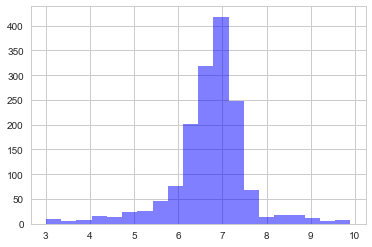

In [414]:
num_bins = 20
n, bins, patches = plt.hist(df_mpg.mpg, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [415]:
# Make a classification based on mpg. Good > 7, Avergage 5.5-7 and Bad < 5.5
df_mpg['class'] = np.where(df_mpg['mpg']>7, 'Good', 'Avergage')
#df_mpg['class'] = np.where((df_mpg['mpg'] >= 5.5) & (df_mpg['mpg'] < 7), 'Average', 'Bad')
df_mpg['class'] = np.where((df_mpg['mpg'] < 5.5) , 'Bad', 'Average')
#df['elderly'] = np.where(df['age']>=50, 'yes', 'no')

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [416]:
df_mpg.head()

,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg,class
0,ABBV,1821,174238.5,233502.4,59263.9,8288.76,7.149911,Average
1,ADAG,1857,119691.4,148476.9,28785.5,4064.35,7.082436,Average
2,ADAR,1950,69148.0,226432.8,157284.8,21798.23,7.215485,Average
3,ALBJ,1558,478726.4,505196.5,26470.1,4373.40,6.052522,Average
4,ALBJ,1743,423467.7,463570.1,40102.4,5779.27,6.939008,Average


In [417]:
def classify_driver(row):
    if row['mpg'] >= 7:
        val = 'Good'
    elif row['mpg'] >= 5.5:
        val = 'Average'
    else:
        val = 'Bad'
    return val

df_mpg['class'] = df_mpg.apply(classify_driver, axis=1)
df_mpg.head()

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg,class
0,ABBV,1821,174238.5,233502.4,59263.9,8288.76,7.149911,Good
1,ADAG,1857,119691.4,148476.9,28785.5,4064.35,7.082436,Good
2,ADAR,1950,69148.0,226432.8,157284.8,21798.23,7.215485,Good
3,ALBJ,1558,478726.4,505196.5,26470.1,4373.40,6.052522,Average
4,ALBJ,1743,423467.7,463570.1,40102.4,5779.27,6.939008,Average


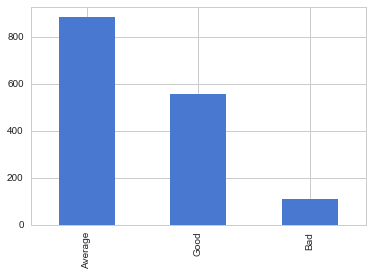

In [418]:
#num_bins = 3
#n, bins, patches = plt.hist(df_mpg.class, num_bins, facecolor='blue', alpha=0.5)
#plt.show()
df_mpg['class'].value_counts().plot(kind='bar')
plt.show()

In [419]:
df_mpg.head()

,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg,class
0,ABBV,1821,174238.5,233502.4,59263.9,8288.76,7.149911,Good
1,ADAG,1857,119691.4,148476.9,28785.5,4064.35,7.082436,Good
2,ADAR,1950,69148.0,226432.8,157284.8,21798.23,7.215485,Good
3,ALBJ,1558,478726.4,505196.5,26470.1,4373.40,6.052522,Average
4,ALBJ,1743,423467.7,463570.1,40102.4,5779.27,6.939008,Average


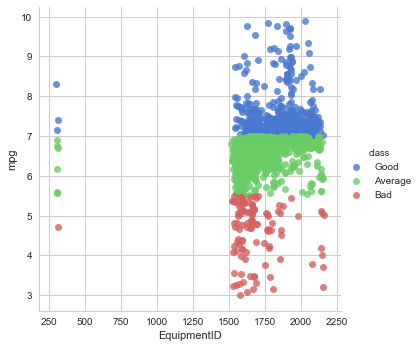

In [420]:
#plot data with seaborn
facet = sns.lmplot(data=df_mpg, x='EquipmentID', y='mpg', hue='class', 
                   fit_reg=False, legend=True, legend_out=True)
plt.show()

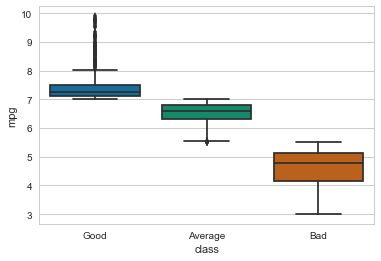

In [421]:
bplot = sns.boxplot(y='mpg', x='class', data = df_mpg, width=0.8, palette="colorblind")
plt.show()

In [422]:
#df.loc[df['column_name'] == some_value]
#print(df_mpg.loc[df_mpg['DriverID']=='BEVL'])
df_mpg[df_mpg.DriverID =='MARC']
#df_mpg.head()

,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg,class
978,MARC,1958,76466.8,264055.8,187589.0,24910.43,7.53054,Good


In [423]:
# Add Great Drivers list for comparison and setting values of class
driver_list = ['SMID', 'BEVL', 'RICS', 'NEWR', 'MARC', 'LOVH']
#filtered_data = df_mileage[df_mileage.DriverID == 'MARC']
#driver_list = {'SMID':'Great', 'BEVL':'Great', 'RICS':'Great', 'NEWR':'Great', 'MARC':'Great', 'LOVH':'Great'}
#df_mpg['class'] = np.where[df_mpg['DriverID'].isin(driver_list), 'Great', df_mpg['class']]
#np.where(df_mpg['mpg']>7, 'Good', 'Avergage')
#df_mpg.head()
#d = {'NONANE':9, 'OCTANE':8, 'HEPTANE':7, 'HEXANE':6}
#df['num'] = df['solvent'].map(d)
#df_mpg.loc[df_mpg['DriverID'].isin(driver_list), 'Class'] = 'Great'
df_mpg.loc[df_mpg.DriverID == 'SMID', 'class'] = 'Great'
df_mpg.loc[df_mpg['DriverID'] == 'BEVL', 'class'] = 'Great'
df_mpg.loc[df_mpg['DriverID'] == 'RICS', 'class'] = 'Great'
df_mpg.loc[df_mpg['DriverID'] == 'NEWR', 'class'] = 'Great'
df_mpg.loc[df_mpg['DriverID'] == 'MARC', 'class'] = 'Great'
df_mpg.loc[df_mpg['DriverID'] == 'LOVH', 'class'] = 'Great'
#df_mpg.loc[df_mpg['Class'] == 'Great']
df_mpg.describe()
#df_mpg.loc['Class'] = df_mpg['DriverID'].map(driver_list)
#df_mpg.head(100)
#df_mpg.loc[df_mpg['DriverID'].isin(driver_list), :]
df_mpg.head()
df_mpg[df_mpg.DriverID == 'MARC']

/Users/vinaykhedkar/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg,class
978,MARC,1958,76466.8,264055.8,187589.0,24910.43,7.53054,Great


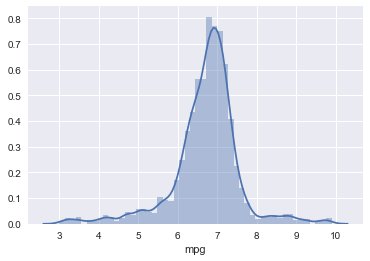

In [424]:

sns.set(color_codes=True)
sns.distplot(df_mpg.mpg);
plt.show()

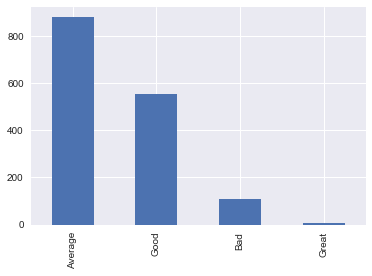

In [425]:
df_mpg['class'].value_counts().plot(kind='bar')
plt.show()

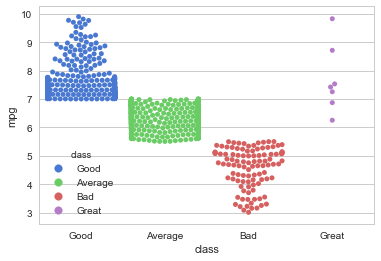

In [426]:
# Draw a categorical scatterplot to show each observation
sns.set(style="whitegrid", palette="muted")
sns.swarmplot(x="class", y="mpg", hue="class", data=df_mpg)
plt.show()

# Detecting Fraud

In [367]:
# find bad mpg drivers
df_bad_drivers = df_mpg[df_mpg['class'] == 'Bad']
#filtered_data = df[df.topping == 'pineapple']
df_bad_drivers.head()

,DriverID,EquipmentID,lowest,highest,miles,fuel,mpg,class
30,ARCM,1570,539886.0,540347.9,461.9,140.50,3.287544,Bad
48,AUSGE,1770,384161.7,385319.7,1158.0,248.99,4.650789,Bad
177,BROD03,1580,514201.2,515506.5,1305.3,328.37,3.975089,Bad
181,BROM01,1591,520447.5,522381.5,1934.0,441.62,4.379331,Bad
206,BUNC,1562,534775.3,536537.4,1762.1,348.83,5.051458,Bad


In [380]:
df = pd.merge(event_f_df, level_f_df, how='inner', left_on=['Id'], right_on = ['ExactFuelEventId'])
dfs = df[['EventTimeStamp', 'EquipmentID', 'DriverID', 'Odometer','IgnitionStatus','TankLevelGallons']]
# calculate fuel difference between each set of rows
dfs = dfs[(dfs['DriverID'] == 'BUNC') & (dfs['IgnitionStatus'] == 2)]

dfs = dfs.sort_values(by=['EventTimeStamp','EquipmentID','DriverID','Odometer'])

#dfs['odo_diff'] = dfs['Odometer'].shift(-1) -  dfs['Odometer']
dfs['odo_diff'] = dfs['Odometer'].diff()
dfs['fuel_diff'] = dfs['TankLevelGallons'].diff()
dfs.loc[dfs.EquipmentID != dfs.EquipmentID.shift(), 'odo_diff'] = 0
dfs.loc[dfs.EquipmentID != dfs.EquipmentID.shift(), 'fuel_diff'] = 0


dfs.head()

,EventTimeStamp,EquipmentID,DriverID,Odometer,IgnitionStatus,TankLevelGallons,odo_diff,fuel_diff
1236689,2017-03-15 07:29:06.937,1562,BUNC,534775.3,2,50.25,0.0,0.00
1237256,2017-03-15 07:57:57.313,1562,BUNC,534775.3,2,50.00,0.0,-0.25
1237269,2017-03-15 07:58:27.327,1562,BUNC,534775.3,2,50.00,0.0,0.00
1238286,2017-03-15 08:46:17.467,1562,BUNC,534796.9,2,46.50,21.6,-3.50
1238335,2017-03-15 08:48:07.467,1562,BUNC,534796.9,2,46.50,0.0,0.00


In [382]:
df_doubt = dfs[(dfs['odo_diff'] == 0) & (dfs['fuel_diff'] < -1)]
df_doubt

,EventTimeStamp,EquipmentID,DriverID,Odometer,IgnitionStatus,TankLevelGallons,odo_diff,fuel_diff
1715016,2017-04-11 10:52:10.957,1664,BUNC,392947.3,2,162.15,0.0,-2.30
1726878,2017-04-11 22:15:55.577,1664,BUNC,392983.3,2,143.52,0.0,-2.76
1747922,2017-04-12 20:58:30.727,1664,BUNC,393379.9,2,128.80,0.0,-8.97
1799903,2017-04-16 04:40:11.447,1664,BUNC,395035.0,2,172.96,0.0,-3.45
1821917,2017-04-17 16:42:33.003,1664,BUNC,395892.3,2,159.39,0.0,-1.84
1827424,2017-04-18 04:02:47.280,1664,BUNC,395892.7,2,143.52,0.0,-11.50
1862708,2017-04-19 15:41:07.937,1664,BUNC,396326.2,2,98.90,0.0,-5.75
1998619,2017-04-27 08:53:28.547,1664,BUNC,398722.4,2,210.45,0.0,-19.55
2208210,2017-05-09 12:40:26.813,1664,BUNC,402470.6,2,187.22,0.0,-1.15
2230520,2017-05-10 12:04:41.540,1664,BUNC,403052.4,2,105.80,0.0,-2.99


In [398]:
dq = dfs[(dfs['Odometer'] == 203784.3) ]
dq

,EventTimeStamp,EquipmentID,DriverID,Odometer,IgnitionStatus,TankLevelGallons,odo_diff,fuel_diff
5376210,2017-10-31 10:49:36.217,1857,BUNC,203784.3,2,183.6,0.1,2.0
5376225,2017-10-31 10:50:16.247,1857,BUNC,203784.3,2,183.6,0.0,0.0
5376281,2017-10-31 10:52:36.217,1857,BUNC,203784.3,2,179.4,0.0,-4.2
5376337,2017-10-31 10:53:56.217,1857,BUNC,203784.3,2,179.4,0.0,0.0
5377086,2017-10-31 11:24:46.217,1857,BUNC,203784.3,2,179.4,0.0,0.0
5377153,2017-10-31 11:26:36.217,1857,BUNC,203784.3,2,179.4,0.0,0.0
5377506,2017-10-31 11:39:56.467,1857,BUNC,203784.3,2,167.0,0.0,-12.4
5377507,2017-10-31 11:40:19.747,1857,BUNC,203784.3,2,167.0,0.0,0.0
5377936,2017-10-31 11:58:46.717,1857,BUNC,203784.3,2,167.0,0.0,0.0
5378017,2017-10-31 12:01:16.717,1857,BUNC,203784.3,2,167.0,0.0,0.0


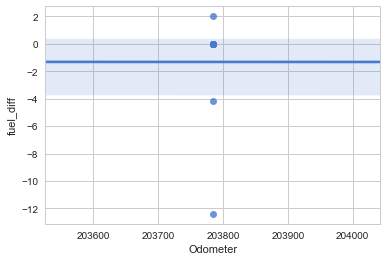

In [402]:
# use the function regplot to make a scatterplot
sns.regplot(x=dq["Odometer"], y=dq["fuel_diff"])
plt.show()
 
# Without regression fit:
#sns.regplot(x=dfs["Odometer"], y=dfs["TankLevelGallons"], fit_reg=False)
#sns.plt.show()


##### Downsizing the databases
To do this, we eliminate all drivers/trucks that have invalid syntax, followed by reducing the databases that contain these elements

In [ ]:
# Here all the valid drivers and trucks are inner-joined (intersected), to be used for downsizing the database.

valid_driv = [x for x in valid_driv_t if (x in valid_driv_e)]

# 2 step inner join for tricks
valid_truck = [x for x in valid_trucks_e if (x in valid_trucks_o)]
valid_trux = [x for x in valid_truck if (x in valid_trucks_t)]

In [ ]:
# Downsizing dataframes take place here.

# optimization
optim_f_df_ds = optim_f_df[optim_f_df.TRUCK.isin(valid_trux) == True]
# events
event_f_df_ds = event_f_df[(event_f_df.EquipmentID.isin(valid_trux) == True) & (event_f_df.DriverID.isin(valid_driv) == True)]
# Transactions
trans_f_df['numtruc'] = pd.to_numeric(trans_f_df['TRNUNT'], errors='coerce')
trans_f_df_ds = trans_f_df[(trans_f_df.TRNDRI.isin(valid_driv) == True) & (trans_f_df.numtruc.isin(valid_trux) == True)]

# Fraudulent Transaction Column

In [ ]:
df_fraud = pd.merge(event_f_df, level_f_df, how='inner', left_on=['Id'], right_on = ['ExactFuelEventId'])
#df_merged = pd.merge(df_mileage, df_fuel_by_truck_driver, on=['DriverID','EquipmentID'])
#new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])
df_fraud.head()

### Merging data sets and cleaning columns

In [ ]:
# Merge database
fuel_trak_df = pd.merge(event_f_df_ds, level_f_df, how='inner', left_on='Id', right_on='ExactFuelEventId')
# discard duplicate columns
fuel_trak_df = fuel_trak_df.drop(['Id_x','Id_y'], axis=1)

In [ ]:
# Columns added to allocate differences in nextcoming steps

fuel_trak_df = fuel_trak_df.assign(dif_Speed="")
fuel_trak_df = fuel_trak_df.assign(dif_ODO="")
fuel_trak_df = fuel_trak_df.assign(dif_tanklevel="")
fuel_trak_df = fuel_trak_df.assign(dif_tankperc="")

In [ ]:
print(len(valid_trux), len(list(set(fuel_trak_df.EquipmentID))))

In [ ]:
level_f_df.head(3)

In [ ]:
level_f_df.head(3)

In [ ]:
fuel_trak_df.sort_values(by = 'EventTimeStamp', axis=0)

# Data Dictionary
 Fuel Analysis Project
 
###### BGETCHDATA.PTCHTRANH

1.	TRNID		Transaction ID 
2.	TRNDAT	    Transaction Date (YYYYMMDD)
3.	TRNTIM		Transaction Time (HHMM)
4.	TRNTS#		Station ID
5.	TRNTSN		Station Name
6.	TRNSTC		Station City
7.	TRNST		Station State
8.	TRNDRI		Driver Code
9.	TRNUNT	    Unit ID
10.	TRNPI1		Item Code 1
11.	TRNPQ1	    Item Quantity 1
12.	TRNPI2		Item Code 2
13.	TRNPQ2	    Item Quantity 2
14.	TRNPI3		Item Code 3
15.	TRNPQ3	    Item Quantity 3
16.	TRNPI4		Item Code 4
17.	TRNPQ4	    Item Quantity 4
18.	TRNPI5		Item Code 5
19.	TRNPQ5	    Item Quantity 5
20.	TRNPI6		Item Code 6
21.	TRNPQ6      Item Quantity 6

Actual fuel transactions will have an item code of ULSD or FUEL, CDSL, DSL1, BDSL, and could be in any of the Item slots 1-6
 

###### IBGEFILE.UNITS

1.	UNUNIT	Unit Number
2.	UNYEAR	Model Year
3.	UNMAKE	Make
4.	UNSER	VIN

###### BGEIDSC.EF2EFFP

1.	TRUCK		Unit Number
2.	ACTIVE		Active Flag (for fuel optimization)
3.	SENDFUEL	Send Fuel Flag (for fuel optimization)
4.	SENDROUTE	Send Route Flag (for fuel optimization)
5.	TANKCAP	    Tank Capacity (gallons)
6.	AVGMPG	    MPG used for Fuel optimization (real value is closer to 7mpg)

###### Extranet2.ExactFuelEvent

1.	Id			    AutoNumber ID
2.	ESS_Id			Omnitracs Event Subscriber Service Event Id
3.	EventTimeStamp	DateTime of Event (normalized to Central Time)
4.	EquipmentID		Unit Number
5.	MCTNumber		Mobile Communications Terminal ID
6.	EquipmentType	should always read ‘tractor’
7.	DriverId		Driver Code Assigned to unit at time of reading (varchar(6))
8.	Latitude		decimal degrees latitude at time of reading
9.	Longitude		decimal degrees longitude at time of reading
10.	LocationTimeStamp 	DateTime of location reading
11.	Speed			MPH at time of reading
12.	Heading		    direction of travel at time of reading
13.	Odometer		unit odometer at time of reading
14.	IgnitionStatus	1=on, 2=off
15.	EFReportReason	0=ignition on, 1=ignition off, 2=timer

###### Extranet2.ExactFuelTankLevel

1.	Id			        AutoNumber id
2.	TankId			    Tank Sensor # (for our trucks, will always be 1)
3.	TankLevelPercent	Percentage Reading 0-100.00
4.	TankLevelGallons	Gallons (Percentage * Tank Capacity) (calculated)
5.	ExactFuelEventId	Foreign Key to ExactFuelEvent

##### Extranet2.QCPerformanceExtracts
See Mary's post on slack 
https://nashvillesoftware.slack.com/files/U71DCPYBX/FAF8Q7JSZ/screen_shot_2018-04-28_at_9.03.29_am.png

# STEPS TO TAKE
+ Identify invalid Trucks/Driver names
+ Convert into valid syntax (numeric etc)
+ Make an intersection of all Trucks & Drivers and create a final list of good IDs for trucks and drivers
+ Extract records with only "good" IDs (downsizing the database)
+ Merge dataframes (subject to discussion)
+ Added extra columns for allocating differences
+ Sort By time

TO DO:
- Write a FOR loop to 
    a. filter the dataframe by each truck
    b. calculate the differences and allocate them in columns (calculate shift)